<a href="https://colab.research.google.com/github/bob123kk/NLP-Question-Answering/blob/master/Kaggle_Q%26A_LightGBM_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-Levenshtein
!pip install contractions
!pip install fuzzywuzzy

     |████████████████████████████████| 50 kB 4.1 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149858 sha256=34a5467d0ed69b045e40305e545323bb2a1cb86ff8ab9b8d61c8071624609268
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein
     |████████████████████████████████| 321 kB 8.0 MB/s 
     |████████████████████████████████| 283 kB 15.1 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85442 sha256=d4ac0c2818ea97b71fde16a44104d69f0fa13650578c436ad179e744eed057e2
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [2]:
import os
import gc
import json
import numpy as np 
import pandas as pd
import pickle
import re
import Levenshtein
import unicodedata
import lightgbm as lgb
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from scipy import spatial
from gensim.models import Word2Vec
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler   
from sklearn.metrics import pairwise_distances    
from sklearn.metrics import accuracy_score,recall_score, f1_score,confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
class Pipeline:
    
    def __init__(self, path, size, test_size, methods, w2v_model_path,lgb_params):
        
        self.path=path
        self.size=size
        self.test_size=test_size
        self.data=None
        self.train_data=None
        self.test_data=None
        self.w2v_model=None
        self.tfidf_QA=None
        self.Q_trfmd=None
        self.A_trfmd=None
        self.Q_tfidf_weights=None
        self.Q_tfidf_weights=None
        self.A_w2v=None
        self.Q_w2v=None
        self.lgb_model=None
        self.w2v_model_path = w2v_model_path
        self.methods = methods
        self.lgb_params=lgb_params

                
    def read_data(self):
        df = []
        with open(self.path, 'rt') as reader:
          for i in range(self.size):
            df.append(json.loads(reader.readline()))
            data = pd.DataFrame(df)

        return data

  
    
    def unstack_dataframe(self,df_train):

        ids = []
        doc = []
        targets = []
        questions = []
        Q_tfidf = []
        candidate_string = []
        C_tfidf = []
        features = []

        for index, row in tqdm(df_train.iterrows()):
        
            # process document text
            doc_text = row['document_text']
            tfidf = TfidfVectorizer()#stop_words=text.ENGLISH_STOP_WORDS)
            tfidf.fit([doc_text])
            
            question_tfidf = tfidf.transform([row['question_text']]).todense()

            start_token_true = row['annotations'][0]['long_answer']['start_token']
            end_token_true = row['annotations'][0]['long_answer']['end_token']

            # Tokenized doc text
            doc_tokenized = row['document_text'].split(' ')
            
            candidates = row['long_answer_candidates']
            # remove nested candidates
            candidates = [c for c in candidates if c['top_level'] == True]

            if start_token_true != -1:
                for c in candidates:
                  ids.append(str(row['example_id']))
                  doc.append([doc_text])
                  
                  questions.append(row['question_text'])
                  Q_tfidf.append(question_tfidf)
                  start_token = c['start_token']
                  end_token = c['end_token']
                  candidate = ' '.join(doc_tokenized[start_token:end_token])
                  candidate_string.append(candidate)
                  candidate_tfidf = tfidf.transform([candidate]).todense()
                  C_tfidf.append(candidate_tfidf)

                  #extract_features

                  token_sort_ratio = fuzz.token_sort_ratio(str(row['question_text']), str(candidate))
                  token_set_ratio = fuzz.token_set_ratio(str(row['question_text']), str(candidate))

                  cos_d = spatial.distance.cosine(question_tfidf, candidate_tfidf)
                  euc_d = np.linalg.norm(question_tfidf - candidate_tfidf)
                  lev_d = Levenshtein.distance(row['question_text'], candidate)
                  lev_r = Levenshtein.ratio(row['question_text'], candidate)
                  jar_s = Levenshtein.jaro(row['question_text'], candidate)
                  jaw_s = Levenshtein.jaro_winkler(row['question_text'], candidate)
                  tfidf_score = np.sum(question_tfidf*candidate_tfidf.T)
                  question_tfidf_sum = np.sum(question_tfidf)
                  answer_tfidf_sum = np.sum(candidate_tfidf)

                  features.append([
                  token_sort_ratio,
                  token_set_ratio,
                  cos_d,
                  euc_d,
                  lev_d,
                  lev_r,
                  jar_s,
                  jaw_s,
                  tfidf_score,  
                  question_tfidf_sum,
                  answer_tfidf_sum,         
                  ])

                  if start_token == start_token_true and end_token == end_token_true:
                    target = 1
                  else:
                    target = 0

                  targets.append(target)


        train = pd.DataFrame()
        train['example_id'] = ids
        train['document'] = doc
        train['question'] = questions
        train['Q_tfidf'] = Q_tfidf
        train['candidate'] = candidate_string
        train['C_tfidf'] = C_tfidf
        train['target'] = targets

        features = np.array(features)
        features_df = pd.DataFrame(features)
        features_df.columns = ['token_sort_ratio',
                              'token_set_ratio', 
                              'cos_d','euc_d',
                              'lev_d','lev_r',
                              'jar_s','jaw_s',
                              'tfidf_score', 
                              'question_tfidf_sum',
                              'answer_tfidf_sum'  ]
        train = pd.concat([train, features_df], axis=1)

        return train

    def train_test_split_here(self):
        self.data = self.read_data()
        self.train_data,self.test_data = train_test_split(self.data, test_size=self.test_size, random_state=42)
        self.train_data=self.unstack_dataframe(self.train_data)
        self.test_data=self.unstack_dataframe(self.test_data)
        
        return self

    def get_tokenized(self,data):

        series = pd.Series(pd.concat([data['question'],data['candidate']]), dtype=str) 
        series.dropna()
        for row in series:
          
            yield row.split(' ')

    def build_model_w2v(self,data):
        

        token_train = [x for x in self.get_tokenized(data)]
        # building a word2vec neural network on training set
        model_w2v = Word2Vec(token_train,size = 300)
        Word_model_path = self.w2v_model_path
        model_w2v.intersect_word2vec_format(Word_model_path,
                                            lockf=1.0,
                                            binary=True)
        # training a word2vec neural network
        model_w2v.train(token_train, total_examples=model_w2v.corpus_count, epochs=10)
        self.w2v_model=model_w2v
        return self

        # Should model be saved here?

    def get_token_has_vectors(self,data):
        self.build_model_w2v(data)
        
        for row in self.get_tokenized(data):
          tf_idf_tokens = []  
          for token in row:
            try:
              vector = self.w2v_model.wv[token]
              
              tf_idf_tokens.append(token)
            except:
              continue

          yield np.array(tf_idf_tokens)

    def find_tfidf_weights(self,data):

        pass_through = lambda x:x
        self.tfidf_QA = TfidfVectorizer(analyzer=pass_through)
        # caculating TF_IDF weights for tokens having valid w2v vectors
        token_valid_vec = [x for x in self.get_token_has_vectors(data)]
        X_trfmd = self.tfidf_QA.fit_transform(token_valid_vec)
        # split into Questions and Answers weights
        self.Q_trfmd = X_trfmd[:len(data)]
        self.A_trfmd = X_trfmd[len(data):] 

        return self

    def get_tfidf_weights_and_wv(self,data):
        
        self.find_tfidf_weights(data)
        vocab_dict = {id:word for word, id in self.tfidf_QA.vocabulary_.items()}
        Q_w2v = []
        Q_tfidf_weights = []
        row_records = self.Q_trfmd.shape[0]

        for row in range(row_records):

          word_id = self.Q_trfmd[row,:].nonzero()[1]

          Q_tfidf_weights.append([self.Q_trfmd[row,id] for id in word_id])
          
          Q_w2v.append([self.w2v_model.wv[vocab_dict[id]] for id in word_id])

        self.Q_tfidf_weights=np.array(Q_tfidf_weights)
        self.Q_w2v=np.array(Q_w2v)
        
        A_w2v = []
        A_tfidf_weights = []
        row_records = self.A_trfmd.shape[0]

        for row in range(row_records):

          word_id = self.A_trfmd[row,:].nonzero()[1]

          A_tfidf_weights.append([self.A_trfmd[row,id] for id in word_id])
          
          A_w2v.append([self.w2v_model.wv[vocab_dict[id]] for id in word_id])

        self.A_tfidf_weights=np.array(A_tfidf_weights)
        self.A_w2v=np.array(A_w2v)
        return self

    def compute(self,wv_Q,wv_A,weight_Q,weight_A,method):
        temp = []
        c = 1
        for row in zip(wv_Q,wv_A,weight_Q,weight_A):

          if row:
            Q_v,A_v,Q_w,A_w = row
            
            Q_w =np.array(Q_w).reshape(-1,1)
            A_w =np.array(A_w).reshape(-1,1)

            dist = pairwise_distances(Q_v,A_v,metric=method)
            weights = np.matmul(Q_w,A_w.T)
            
            weighted_avg = np.average(dist,weights=weights)
            temp.append(weighted_avg)

          else:
            temp.append(np.nan)
          c+=1
        return temp   

    def preprocess(self,data):

      self.get_tfidf_weights_and_wv(data)

      features = []
      for method in self.methods:
        feature = self.compute(wv_Q=self.Q_w2v,                             
                               wv_A=self.A_w2v, 
                               weight_Q=self.Q_tfidf_weights,
                               weight_A=self.A_tfidf_weights,
                               method=method
                               )
        
        features.append(feature)
      
      features = np.array(features).T 
      features_df = pd.DataFrame(features)
      features_df.columns = methods

      train = pd.concat([data, features_df], axis=1)

      print('finish preprocessing')
      return train 

    def fit(self, data):

        train = self.preprocess(data)

        cols_to_drop = ['example_id','document', 'Q_tfidf','C_tfidf','question', 'target','candidate' ]
        feature_train = train.drop(cols_to_drop, axis=1, errors='ignore')
        y_train = train['target'].values
        n_features = feature_train.shape[1]

        # set model config and Kfold
        lgb_params = self.lgb_params

        feature_names = list(feature_train.columns) 

        lgb_train = lgb.Dataset(
            feature_train, 
            y_train, 
            feature_name=feature_names,
            )
        # lgb_train.raw_data = None


        model = lgb.train(
            lgb_params,
            lgb_train,
            num_boost_round=1500
        )

        self.lgb_model = model
        
        print('finish training')
        return self

    def evaluate_model(self, valid):

        cols_to_drop = ['example_id','document', 'Q_tfidf','C_tfidf','target','question','candidate' ]
        feature_valid = valid.drop(cols_to_drop, axis=1, errors='ignore')
        y_valid = valid['target'].values
        n_features = feature_valid.shape[1]

        # model predict
        p = self.lgb_model.predict(feature_valid,num_iteration=self.lgb_model.best_iteration)
        valid['pred'] = p

        max_pred = valid.groupby(['example_id'])['pred'].transform('max')
        valid['pred_target'] = np.where(valid['pred'].eq(max_pred), 1,0)

        pred_df = valid.groupby('example_id').apply(lambda x: x.sort_values(['pred_target'],ascending=False))
        pred_df = pred_df[['example_id','target','question','pred_target','pred','candidate']]

        print('baseline f1 score ',1/pred_df.groupby(level='example_id')['candidate'].count().mean())

        prediction = pred_df.pred_target.values
        actual = pred_df.target.values
        f1_scor = f1_score(actual, prediction,average=None)
        recall_scor = recall_score(actual, prediction,average=None)

        data = {'y_Actual':actual,'y_Predicted': prediction }
        df_result = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
        confusion_matrix = pd.crosstab(df_result['y_Actual'], df_result['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
        sns.heatmap(confusion_matrix, annot=True,fmt="d")

        plt.show()

        print('recall_score: {}, f1_score: {}'.format(recall_scor,f1_scor))

    def predict(self,test):

        cols_to_drop = ['example_id','document', 'Q_tfidf','C_tfidf','target','question','candidate' ]
        feature_test = test.drop(cols_to_drop, axis=1, errors='ignore')

        y_test = test['target'].values
        n_features = feature_test.shape[1]

        # model predict
        p = self.lgb_model.predict(feature_test,num_iteration=self.lgb_model.best_iteration)
        test['pred'] = p

        max_pred = test.groupby(['example_id'])['pred'].transform('max')
        test['pred_target'] = np.where(test['pred'].eq(max_pred), 1,0)

        pred_df = test.groupby('example_id').apply(lambda x: x.sort_values(['pred_target'],ascending=False))
        pred_df = pred_df[['example_id','target','question','pred_target','pred','candidate']]

        return pred_df



In [4]:
path ='/content/drive/My Drive/Q&A Data/tensorflow2-question-answering/simplified-nq-train.jsonl'
w2v_model_path = '/content/drive/My Drive/Word2vec/GoogleNews.bin'
size = 10
methods = ['euclidean','cosine','chebyshev','correlation']
lgb_params={
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'binary_logloss',
            'num_iterations ': 200,
            'max_depth': 7,
            'num_leaves': 80,
            'learning_rate': 0.01, 
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'xgboost_dart_mode': True,
            'verbose': -1, 
            'is_unbalance': False,
            'num_threads': 5
            }

pipeline = Pipeline(path,size,test_size=0.33,methods=methods, 
                    w2v_model_path=w2v_model_path,lgb_params=lgb_params)

pipeline.train_test_split_here()

train_data = pipeline.train_data
test_data = pipeline.test_data

In [5]:
pipeline.fit(train_data)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:217: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:218: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/lo

finish preprocessing
finish training


baseline f1 score  0.05555555555555555


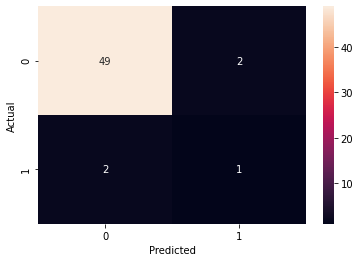

recall_score: [0.96078431 0.33333333], f1_score: [0.96078431 0.33333333]


In [6]:
pipeline.evaluate_model(train_data)


In [7]:
pipeline.predict(test_data)

example_id  ...                                          candidate
example_id                                    ...                                                   
4958098854057393062 17   4958098854057393062  ...  <P> There was already a long history of Acadia...
                    0    4958098854057393062  ...  <P> The Acadians ( French : Acadiens ) are the...
                    37   4958098854057393062  ...     <P> Milestones of the Acadian Renaissance </P>
                    28   4958098854057393062  ...  <P> Some Acadians became indentured servants i...
                    29   4958098854057393062  ...  <P> In 1758 , after the fall of Louisbourg , o...
...                                      ...  ...                                                ...
5655493461695504401 78   5655493461695504401  ...  <P> Email marketing can be carried out through...
                    77   5655493461695504401  ...  <P> Historically , it has been difficult to me...
                    76   5655493461695504401  ...  <P> Email marketing has evolved rapidly alongs...
                    75   5655493461695504401  ...  <P> Email marketing is the act of sending a co...
                    100  5655493461695504401  ...  <P> The CAN - SPAM Act was updated with some n...

[101 rows x 6 columns]